In [7]:
from functools import partial
import logging
import os
import sys
import jax
import haiku as hk
import numpy as np
import dask
import xarray as xr
import matplotlib.pyplot as plt

from graphcast import rollout

from graphufs.training import construct_wrapped_graphcast
from graphufs.batchloader import ExpandedBatchLoader
from graphufs.datasets import Dataset
from graphufs.inference import swap_batch_time_dims, store_container

In [8]:
def predict_custom(
    emulator,
    dataset,
    idx=0,
    ckpt_id=80,
) -> xr.Dataset:

    params, state = emulator.load_checkpoint(id=ckpt_id)

    @hk.transform_with_state
    def run_forward(inputs, targets_template, forcings):
        predictor = construct_wrapped_graphcast(emulator)
        return predictor(inputs, targets_template=targets_template, forcings=forcings)

    def with_params(fn):
        return partial(fn, params=params, state=state)

    def drop_state(fn):
        return lambda **kw: fn(**kw)[0]

    gc = drop_state(with_params(jax.jit(run_forward.apply)))

    inputs, targets, forcings = dataset.get_xarrays(idx)
    inputs.load()
    targets.load()
    forcings.load()

    # retrieve and drop t0
    inittimes = np.atleast_1d(inputs.datetime.isel(time=-2).values)
    inputs = inputs.drop_vars("datetime")
    targets = targets.drop_vars("datetime")
    forcings = forcings.drop_vars("datetime")

    predictions = rollout.chunked_prediction(
        gc,
        rng=jax.random.PRNGKey(0),
        inputs=inputs,
        targets_template=np.nan * targets,
        forcings=forcings,
    )

    # perform output transform, e.g. exp( log_spfh )
    for key, mapping in emulator.output_transforms.items():
        with xr.set_options(keep_attrs=True):
            predictions[key] = mapping(predictions[key])
            targets[key] = mapping(targets[key])
                
    # Add t0 as new variable, and swap out for logical sample/batch index
    predictions = swap_batch_time_dims(predictions, inittimes)
    targets = swap_batch_time_dims(targets, inittimes)

    return predictions, targets

In [9]:
def predict(
    params,
    state,
    emulator,
    batchloader,
) -> xr.Dataset:

    @hk.transform_with_state
    def run_forward(inputs, targets_template, forcings):
        predictor = construct_wrapped_graphcast(emulator)
        return predictor(inputs, targets_template=targets_template, forcings=forcings)

    def with_params(fn):
        return partial(fn, params=params, state=state)

    def drop_state(fn):
        return lambda **kw: fn(**kw)[0]

    logging.info("JIT Compiling Predict")
    gc = drop_state(with_params(jax.jit(run_forward.apply)))
    logging.info("Done Compiling Predict")

    hours = int(emulator.forecast_duration.value / 1e9 / 3600)
    #pname = f"{emulator.local_store_path}/inference/{batchloader.dataset.mode}/graphufs.{hours}h.zarr"
    #tname = f"{emulator.local_store_path}/inference/{batchloader.dataset.mode}/replay.{hours}h.zarr"

    n_steps = len(batchloader)
    print("length of batchloader", n_steps)

    inputs, targets, forcings = batchloader.get_data()    
    #for k, (inputs, targets, forcings) in enumerate(batchloader):
        
    if inputs is not None:
        # retrieve and drop t0
        inittimes = inputs.datetime.isel(time=-1).values
        inputs = inputs.drop_vars("datetime")
        targets = targets.drop_vars("datetime")
        forcings = forcings.drop_vars("datetime")

        # predictions have dims [batch, time (aka forecast_time), level, z_l, lat, lon]
        predictions = rollout.chunked_prediction(
            gc,
            rng=jax.random.PRNGKey(0),
            inputs=inputs,
            targets_template=np.nan * targets,
            forcings=forcings,
        )

        # perform output transform, e.g. exp( log_spfh )
        for key, mapping in emulator.output_transforms.items():
            with xr.set_options(keep_attrs=True):
                predictions[key] = mapping(predictions[key])
                targets[key] = mapping(targets[key])

        # Add t0 as new variable, and swap out for logical sample/batch index
        # swap dims to be [time (aka initial condition time), lead_time (aka forecast_time), level, z_l, lat, lon]
        predictions = swap_batch_time_dims(predictions, inittimes)
        targets = swap_batch_time_dims(targets, inittimes)

        # Store to zarr one batch at a time
        #if k == 0:
        #    store_container(pname, predictions, time=batchloader.initial_times, mode="w")
        #    store_container(tname, targets, time=batchloader.initial_times, mode="w")

                
        # Store to zarr
        #spatial_region = {d: slice(None, None) for d in predictions.dims if d != "time"}
        #st = k*batchloader.batch_size
        #ed = (k+1)*batchloader.batch_size
        #region = {
        #    "time": slice(st, ed),
        #    **spatial_region,
        #}
        #predictions.to_zarr(pname, region=region)
        #targets.to_zarr(tname, region=region)
            
        return predictions, targets 

In [10]:
from prototypes.atm_only.R1.config import Evaluator as Emulator
emulator = Emulator()

In [11]:
vds = Dataset(
    emulator,
    mode="validation",
    preload_batch=False,
)

In [12]:
vds.xds

<xarray.Dataset> Size: 6GB
Dimensions:       (datetime: 241, lat: 192, lon: 384, level: 16)
Coordinates:
  * level         (level) float64 128B 226.1 277.8 327.7 ... 874.7 922.6 974.3
    cftime        (datetime) object 2kB dask.array<chunksize=(241,), meta=np.ndarray>
    ftime         (datetime) timedelta64[ns] 2kB dask.array<chunksize=(241,), meta=np.ndarray>
  * lon           (lon) float64 3kB 0.0 0.9375 1.875 2.812 ... 357.2 358.1 359.1
  * lat           (lat) float64 2kB 89.82 88.89 87.95 ... -87.25 -88.18 -89.12
  * datetime      (datetime) datetime64[ns] 2kB 2022-01-01 ... 2022-01-31
Data variables:
    spfh2m        (datetime, lat, lon) float32 71MB dask.array<chunksize=(1, 192, 384), meta=np.ndarray>
    dswrf_avetoa  (datetime, lat, lon) float32 71MB dask.array<chunksize=(1, 192, 384), meta=np.ndarray>
    vgrd          (datetime, level, lat, lon) float32 1GB dask.array<chunksize=(1, 16, 192, 384), meta=np.ndarray>
    spfh          (datetime, level, lat, lon) float32 1GB dask.array<chunksize=(1, 16, 192, 384), meta=np.ndarray>
    ugrd10m       (datetime, lat, lon) float32 71MB dask.array<chunksize=(1, 192, 384), meta=np.ndarray>
    ugrd          (datetime, level, lat, lon) float32 1GB dask.array<chunksize=(1, 16, 192, 384), meta=np.ndarray>
    tmp2m         (datetime, lat, lon) float32 71MB dask.array<chunksize=(1, 192, 384), meta=np.ndarray>
    pressfc       (datetime, lat, lon) float32 71MB dask.array<chunksize=(1, 192, 384), meta=np.ndarray>
    tmp           (datetime, level, lat, lon) float32 1GB dask.array<chunksize=(1, 16, 192, 384), meta=np.ndarray>
    dzdt          (datetime, level, lat, lon) float32 1GB dask.array<chunksize=(1, 16, 192, 384), meta=np.ndarray>
    vgrd10m       (datetime, lat, lon) float32 71MB dask.array<chunksize=(1, 192, 384), meta=np.ndarray>
    tmpsfc        (datetime, lat, lon) float32 71MB dask.array<chunksize=(1, 192, 384), meta=np.ndarray>

In [ ]:
validator = ExpandedBatchLoader(
    vds,
    batch_size=emulator.batch_size,
    shuffle=False,
    drop_last=False,
    num_workers=0,
    max_queue_size=1,
    sample_stride=emulator.sample_stride,
)

# setup weights
print("Reading weights ...")
ckpt_id = emulator.evaluation_checkpoint_id if emulator.evaluation_checkpoint_id is not None else emulator.num_epochs
params, state = emulator.load_checkpoint(id=ckpt_id)

# Make predictions
predictions, targets = predict(
    params=params,
    state=state,
    emulator=emulator,
    batchloader=validator,
)

validator.shutdown()

In [13]:
predictions = {}
targets = {}
predictions, targets = predict_custom(emulator=emulator, dataset=vds, ckpt_id=80)

/global/homes/n/nagarwal/graph-ufs/graphcast/graphcast/rollout.py:127: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  num_target_steps = targets_template.dims["time"]
/global/homes/n/nagarwal/graph-ufs/graphcast/graphcast/autoregressive.py:200: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  scan_length = targets_template.dims['time']
/global/homes/n/nagarwal/graph-ufs/graphcast/graphcast/autoregressive.py:115: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping

In [14]:
targets

<xarray.Dataset> Size: 1GB
Dimensions:    (time: 1, lead_time: 40, lat: 192, lon: 384, level: 16)
Coordinates:
  * level      (level) float64 128B 226.1 676.2 773.6 ... 825.8 922.6 572.7
  * lon        (lon) float64 3kB 0.0 0.9375 1.875 2.812 ... 357.2 358.1 359.1
  * lat        (lat) float64 2kB 89.82 88.89 87.95 ... -87.25 -88.18 -89.12
  * lead_time  (lead_time) timedelta64[ns] 320B 0 days 06:00:00 ... 10 days 0...
  * time       (time) datetime64[ns] 8B 2022-01-01
Data variables:
    spfh2m     (time, lead_time, lat, lon) float32 12MB 0.0003862 ... 0.0005561
    vgrd       (time, lead_time, level, lat, lon) float32 189MB 12.52 ... -6.873
    ugrd10m    (time, lead_time, lat, lon) float32 12MB -3.744 -3.717 ... -2.449
    tmpsfc     (time, lead_time, lat, lon) float32 12MB 246.4 246.4 ... 247.9
    ugrd       (time, lead_time, level, lat, lon) float32 189MB -14.97 ... 7.715
    tmp2m      (time, lead_time, lat, lon) float32 12MB 248.3 248.3 ... 248.0
    pressfc    (time, lead_time, lat, lon) float32 12MB 1.033e+05 ... 6.954e+04
    tmp        (time, lead_time, level, lat, lon) float32 189MB 204.8 ... 234.9
    dzdt       (time, lead_time, level, lat, lon) float32 189MB -0.009078 ......
    spfh       (time, lead_time, level, lat, lon) float32 189MB 8.12e-06 ... ...
    vgrd10m    (time, lead_time, lat, lon) float32 12MB 1.61 1.67 ... -4.82

## Surface Pressure

In [17]:
itime = 0
ilead = 0

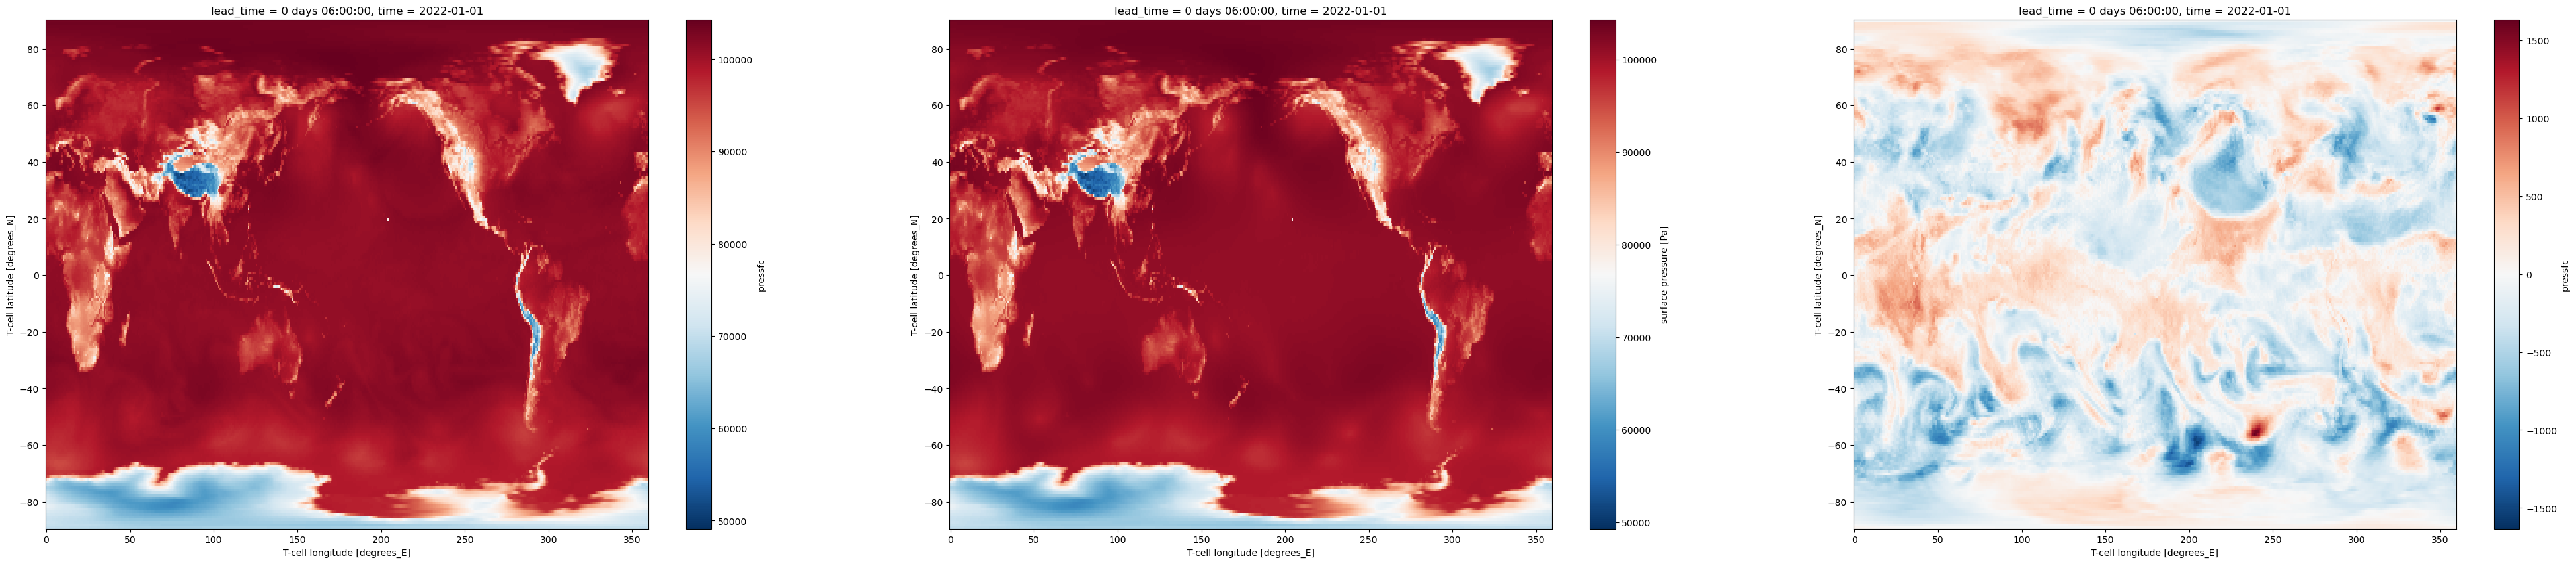

In [18]:
prediction = predictions.pressfc.isel(time=itime, lead_time=ilead)
target = targets.pressfc.isel(time=itime, lead_time=ilead)
diff = prediction - target

# plot
fig, ax = plt.subplots(1, 3, figsize=(50,10))
prediction.plot(ax=ax[0], cmap="RdBu_r")
target.plot(ax=ax[1], cmap="RdBu_r")
diff.plot(ax=ax[2], cmap='RdBu_r')

plt.show()

## Specific Humidity

In [19]:
itime = 0
ilead = 0

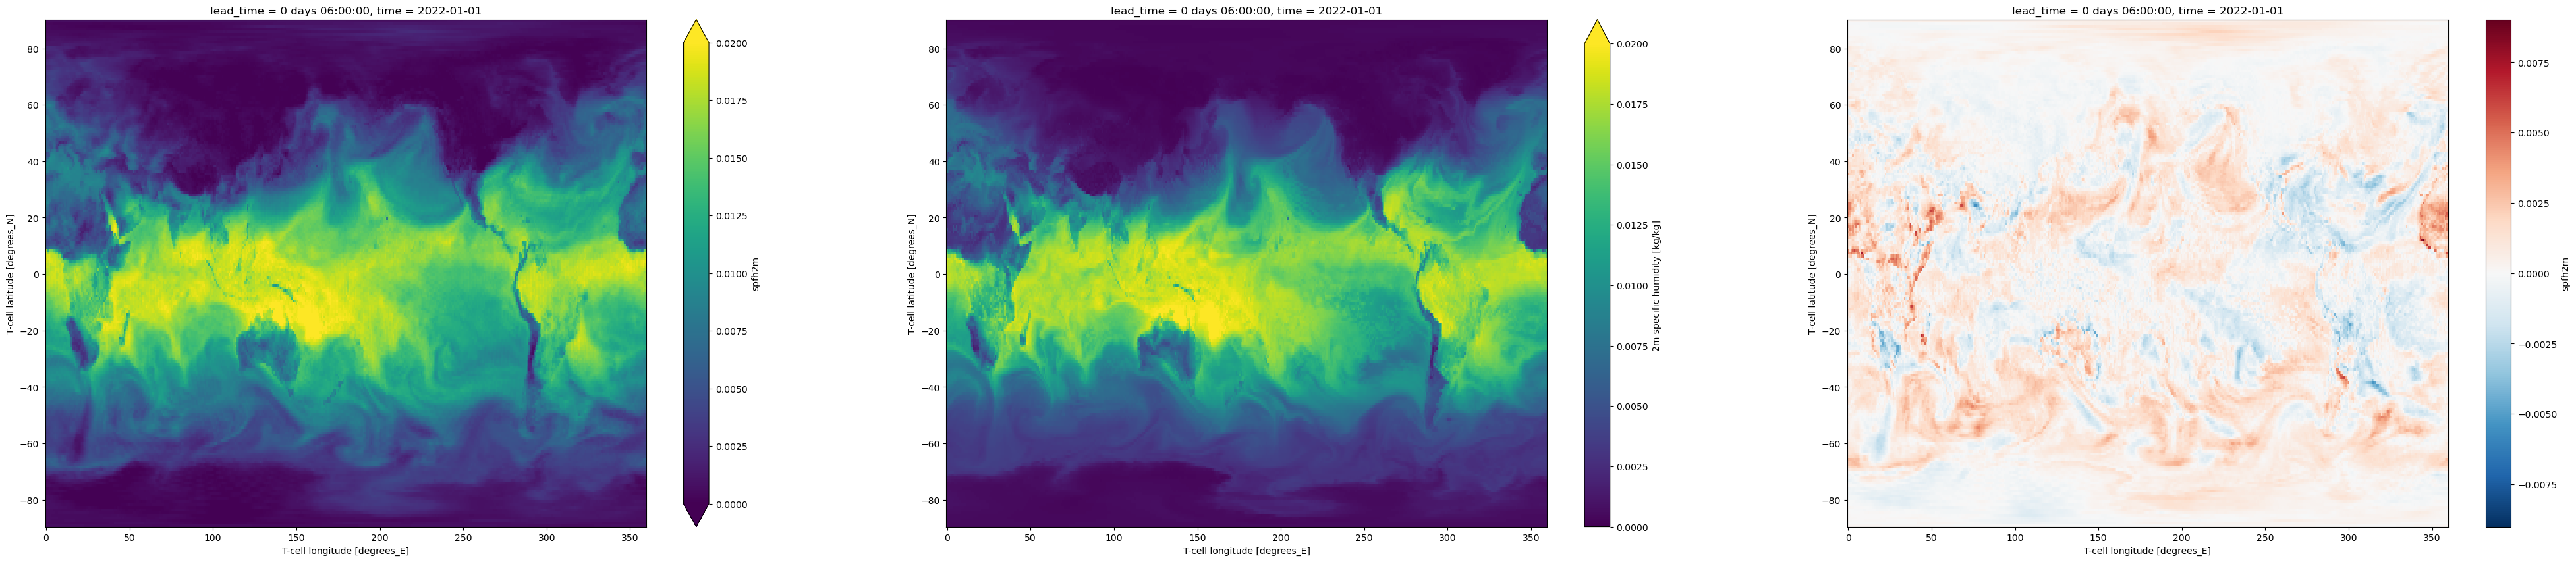

In [28]:
prediction = predictions.spfh2m.isel(time=itime, lead_time=ilead)
target = targets.spfh2m.isel(time=itime, lead_time=ilead)
diff = prediction - target

# plot
fig, ax = plt.subplots(1, 3, figsize=(50,10))
prediction.plot(ax=ax[0], cmap="viridis", vmin=0, vmax=0.02,)
target.plot(ax=ax[1], cmap="viridis", vmin=0, vmax=0.02, )
diff.plot(ax=ax[2], cmap='RdBu_r')

plt.show()

In [56]:
ilevel = -5

In [57]:
prediction = predictions.spfh.isel(time=itime, lead_time=ilead, level=ilevel,)
target = targets.spfh.isel(time=itime, lead_time=ilead, level=ilevel)
diff = prediction - target

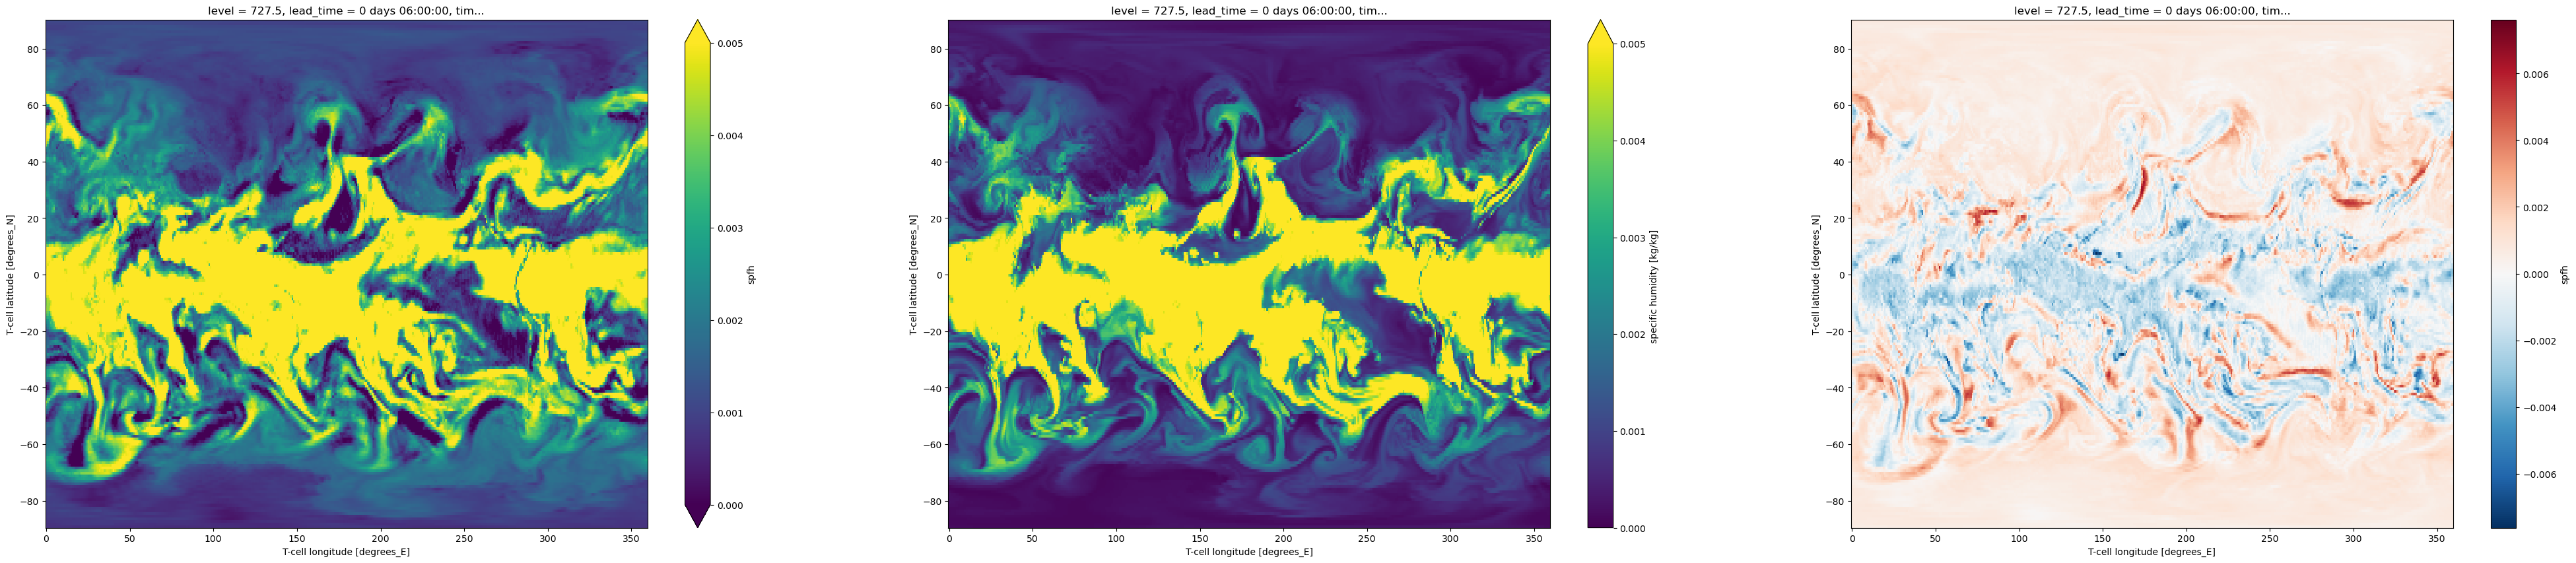

In [58]:
# plot
fig, ax = plt.subplots(1, 3, figsize=(50,10))
prediction.plot(ax=ax[0], cmap="viridis", vmin=0, vmax=0.005)
target.plot(ax=ax[1], cmap="viridis", vmin=0, vmax=0.005)
diff.plot(ax=ax[2], cmap='RdBu_r')

plt.show()

## Temperature

In [94]:
itime = 0
ilead = 0
ilevel = 14

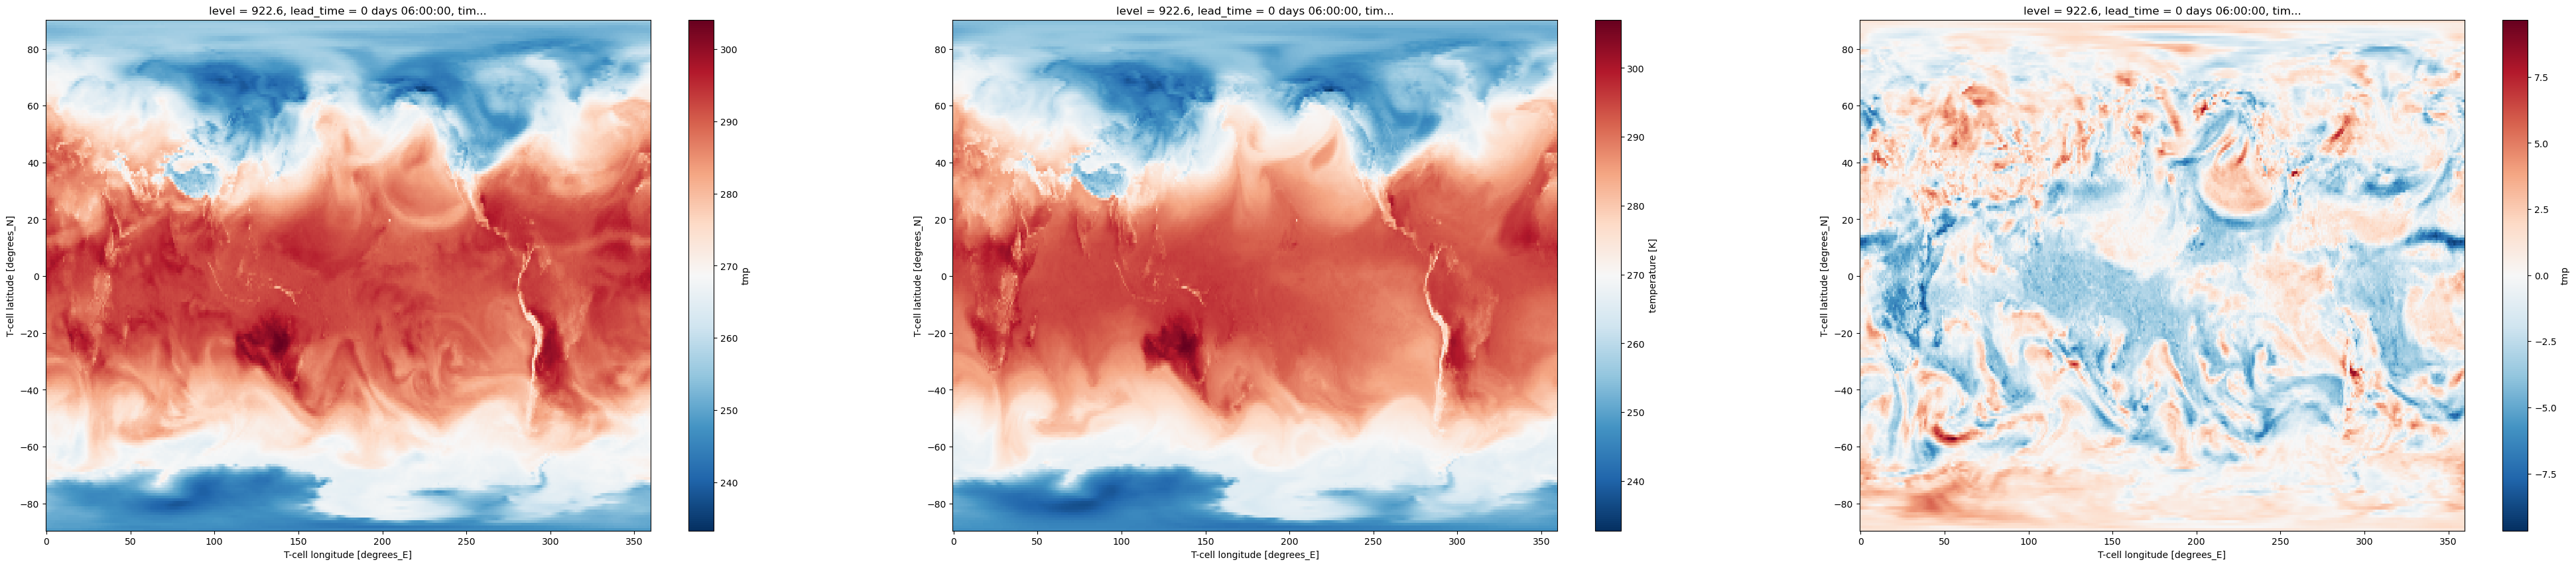

In [95]:
prediction = predictions.tmp.isel(time=itime, lead_time=ilead, level=ilevel)
target = targets.tmp.isel(time=itime, lead_time=ilead, level=ilevel)
diff = prediction - target

# plot
fig, ax = plt.subplots(1, 3, figsize=(50,10))
prediction.plot(ax=ax[0], cmap="RdBu_r")
target.plot(ax=ax[1], cmap="RdBu_r")
diff.plot(ax=ax[2], cmap='RdBu_r')

plt.show()

### tmpsfc

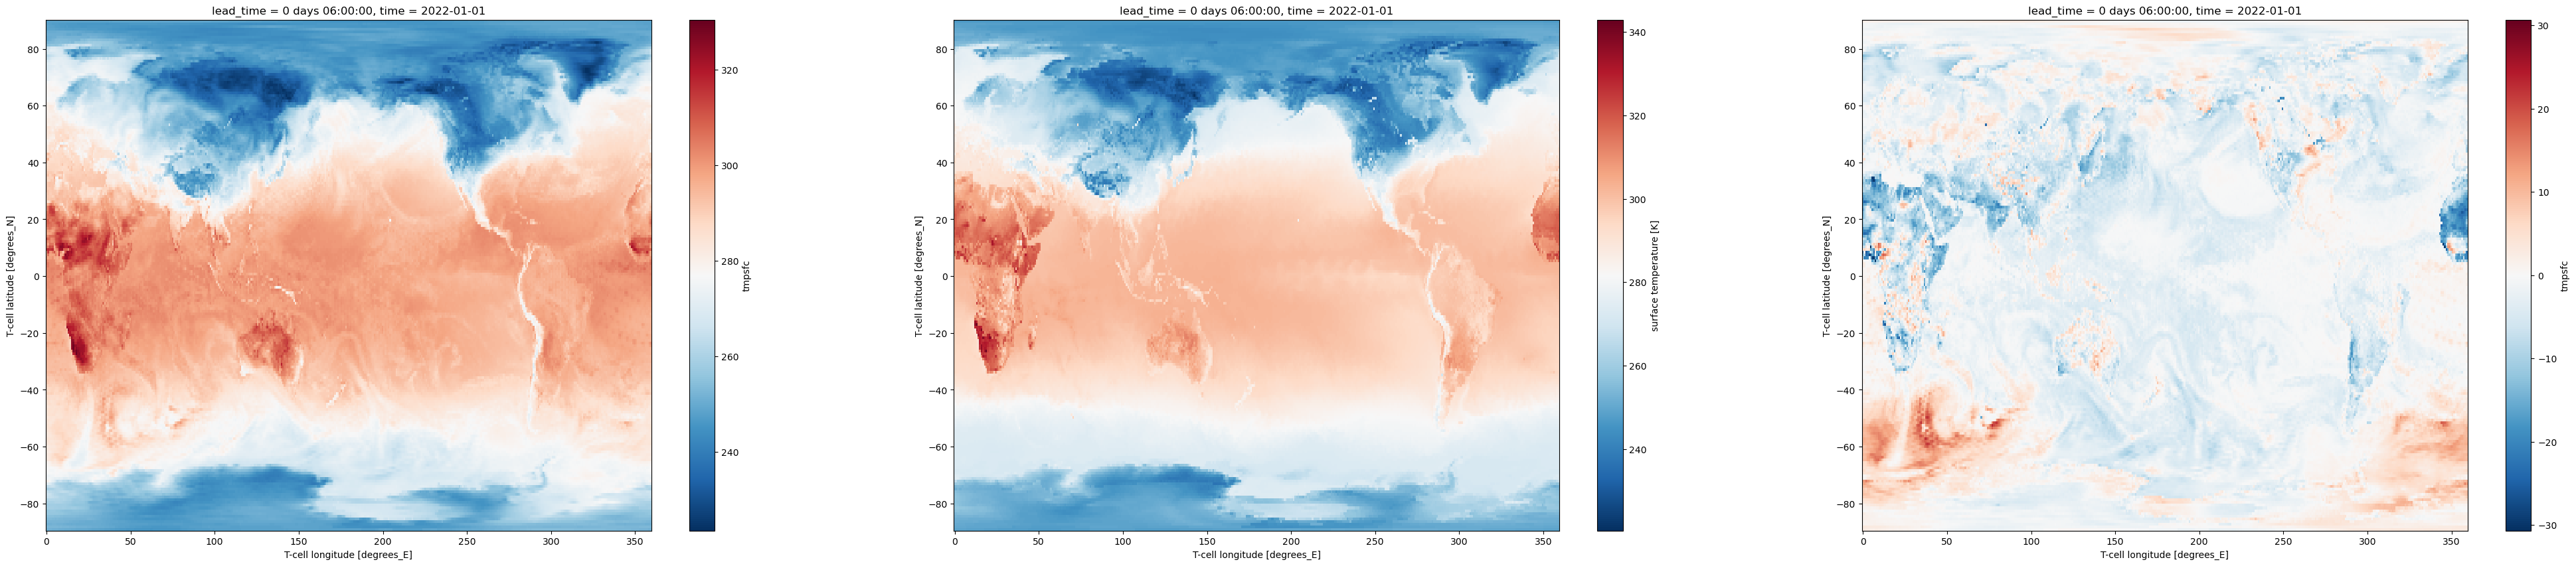

In [97]:
prediction = predictions.tmpsfc.isel(time=itime, lead_time=ilead,)
target = targets.tmpsfc.isel(time=itime, lead_time=ilead,)
diff = prediction - target

# plot
fig, ax = plt.subplots(1, 3, figsize=(50,10))
prediction.plot(ax=ax[0], cmap="RdBu_r")
target.plot(ax=ax[1], cmap="RdBu_r")
diff.plot(ax=ax[2], cmap='RdBu_r')

plt.show()

## SSH

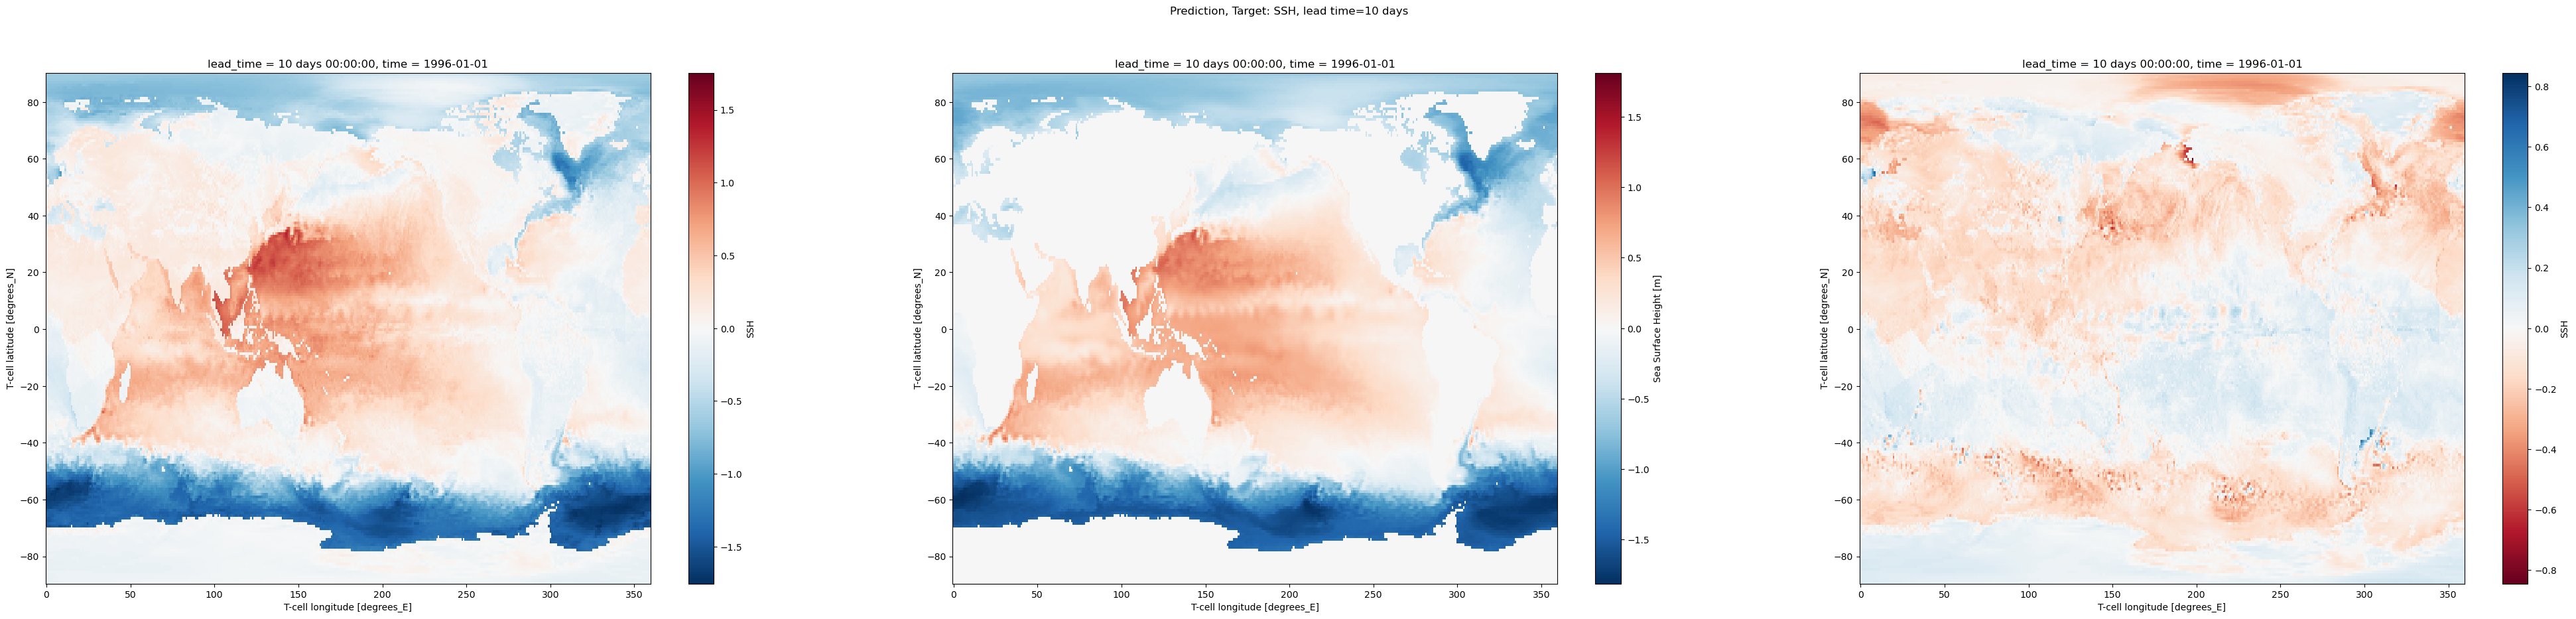

In [9]:
fig, ax = plt.subplots(1, 3, figsize=(50,10))
predictions.SSH.isel(time=0, lead_time=-1).plot(ax=ax[0])
targets.SSH.isel(time=0, lead_time=-1).plot(ax=ax[1])
diff = targets.SSH.isel(time=0, lead_time=-1) - predictions.SSH.isel(time=0, lead_time=-1)
diff.plot(ax=ax[2], cmap='RdBu')
lead_time_days = predictions.lead_time[-1].values.astype('timedelta64[D]')
plt.suptitle(f'Prediction, Target: SSH, lead time={lead_time_days}')
plt.show()

## Sea Ice

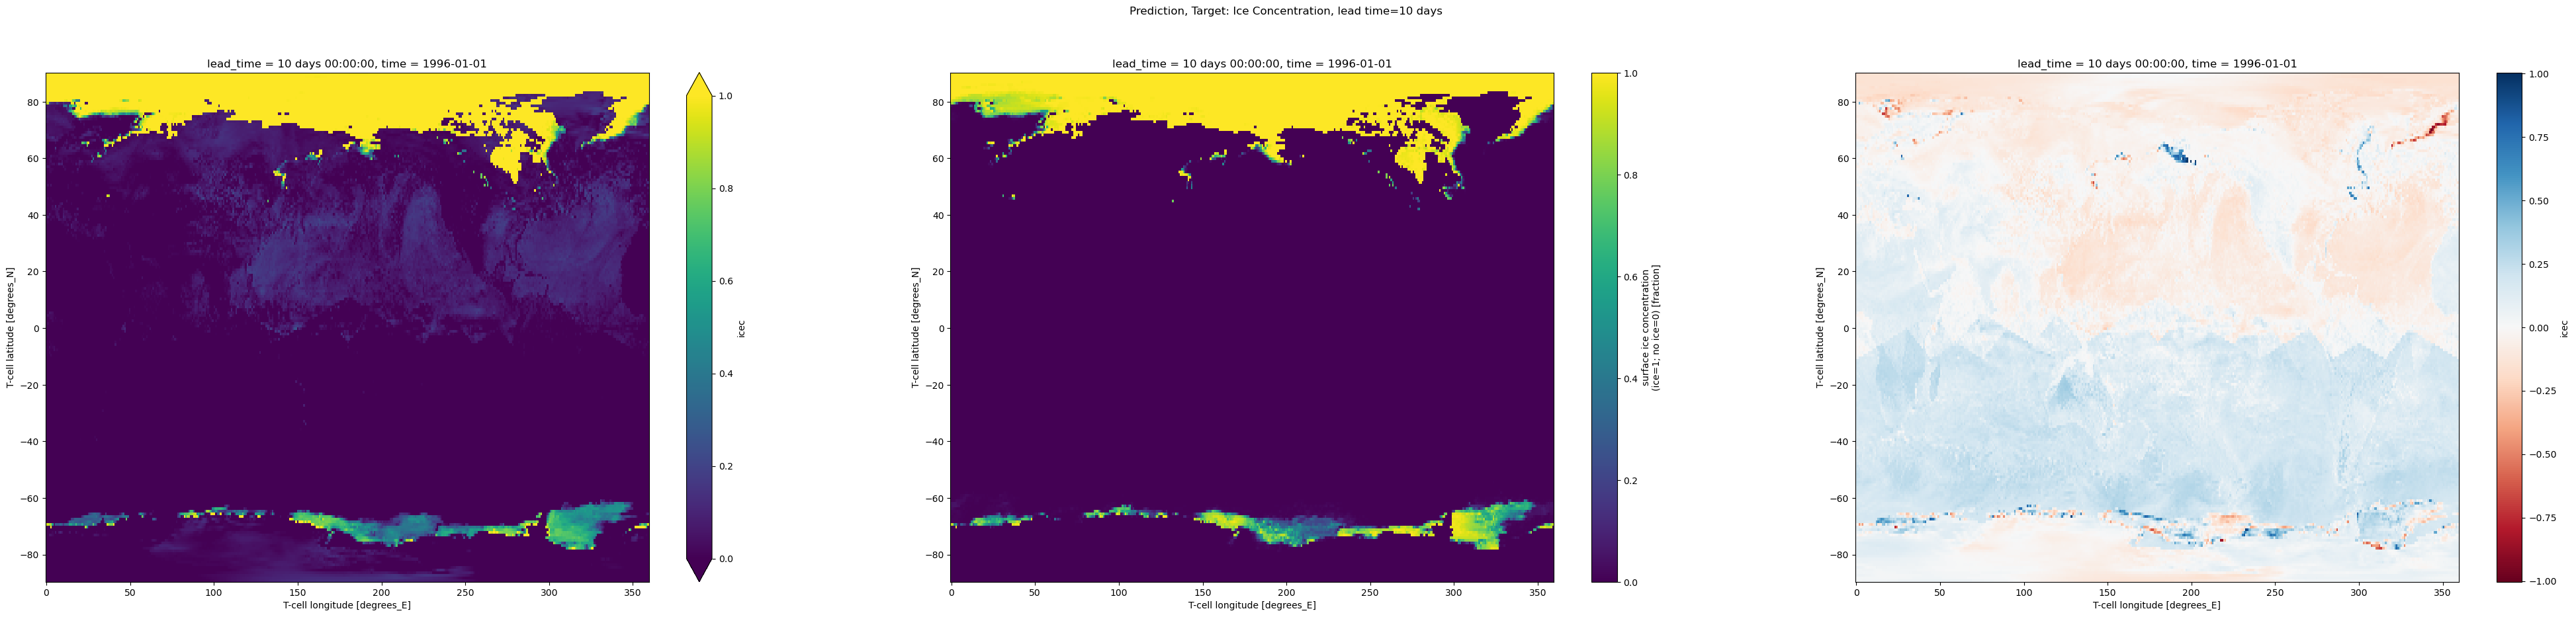

In [10]:
fig, ax = plt.subplots(1, 3, figsize=(50,10))
predictions.icec.isel(time=0, lead_time=-1).plot(ax=ax[0], vmin=0, vmax=1, cmap="viridis")
targets.icec.isel(time=0, lead_time=-1).plot(ax=ax[1])
diff = targets.icec.isel(time=0, lead_time=-1) - predictions.icec.isel(time=0, lead_time=-1)
diff.plot(ax=ax[2], cmap='RdBu')
lead_time_days = predictions.lead_time[-1].values.astype('timedelta64[D]')
plt.suptitle(f'Prediction, Target: Ice Concentration, lead time={lead_time_days}')
plt.show()

## Soil Moisture

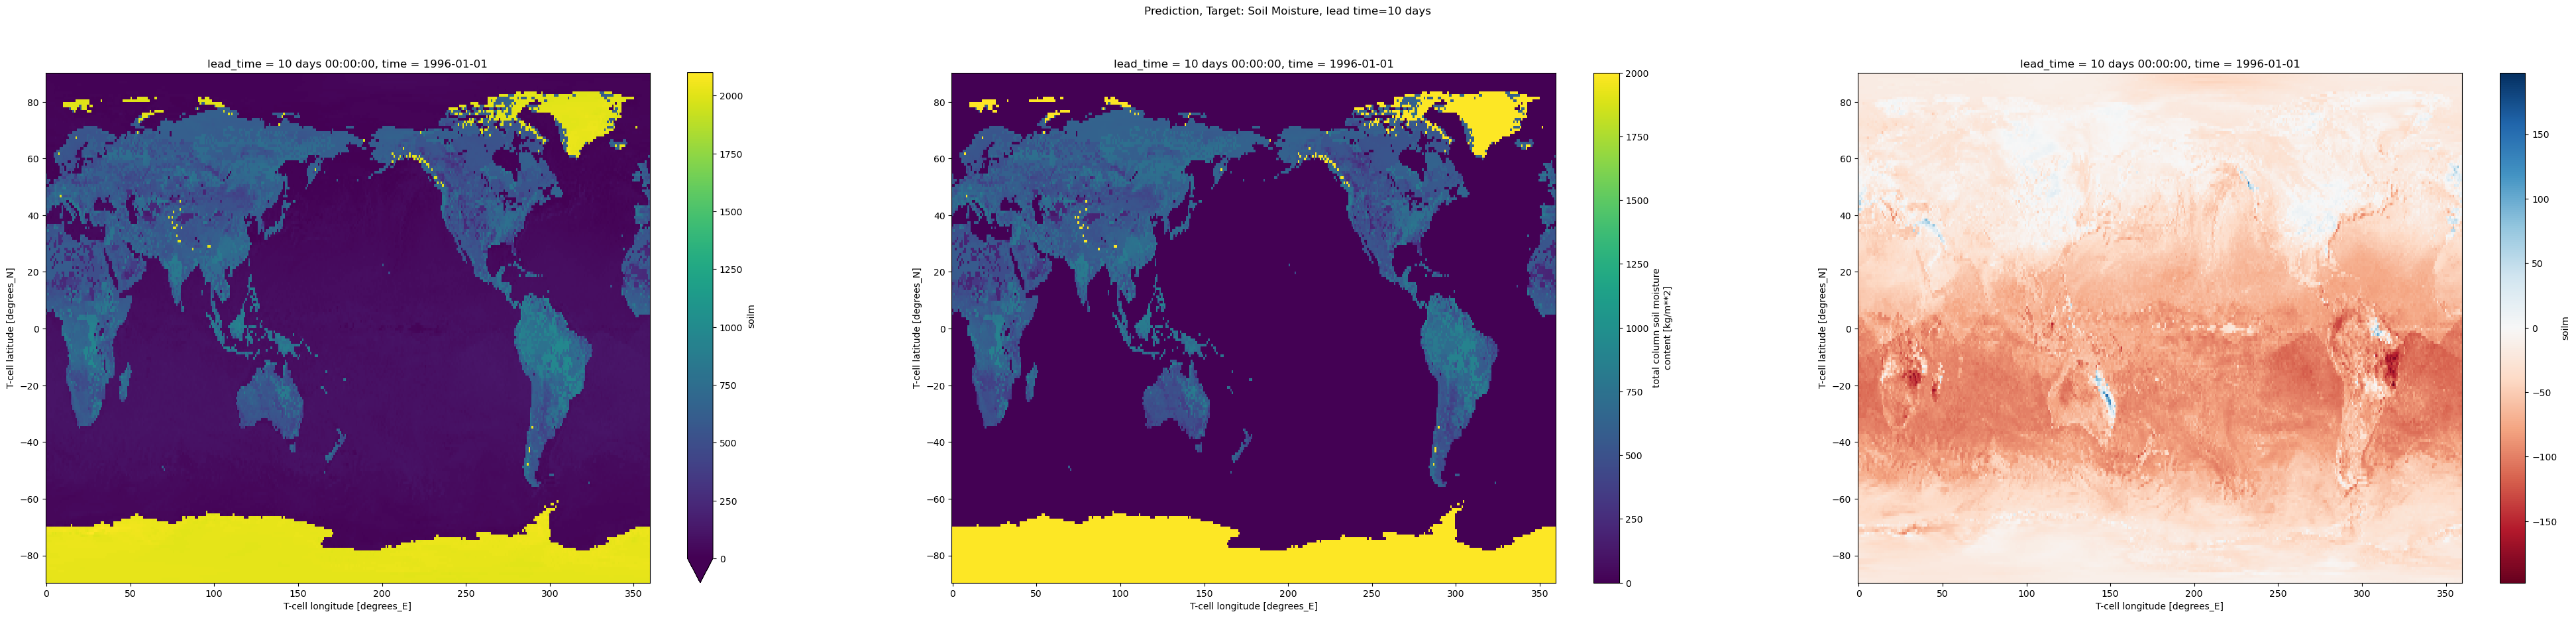

In [11]:
fig, ax = plt.subplots(1, 3, figsize=(50,10))
predictions.soilm.isel(time=0, lead_time=-1).plot(ax=ax[0], cmap="viridis", vmin=0)
targets.soilm.isel(time=0, lead_time=-1).plot(ax=ax[1], cmap="viridis")
diff = targets.soilm.isel(time=0, lead_time=-1) - predictions.soilm.isel(time=0, lead_time=-1)
diff.plot(ax=ax[2], cmap='RdBu')
lead_time_days = predictions.lead_time[-1].values.astype('timedelta64[D]')
plt.suptitle(f'Prediction, Target: Soil Moisture, lead time={lead_time_days}')
plt.show()

## 3D ocean

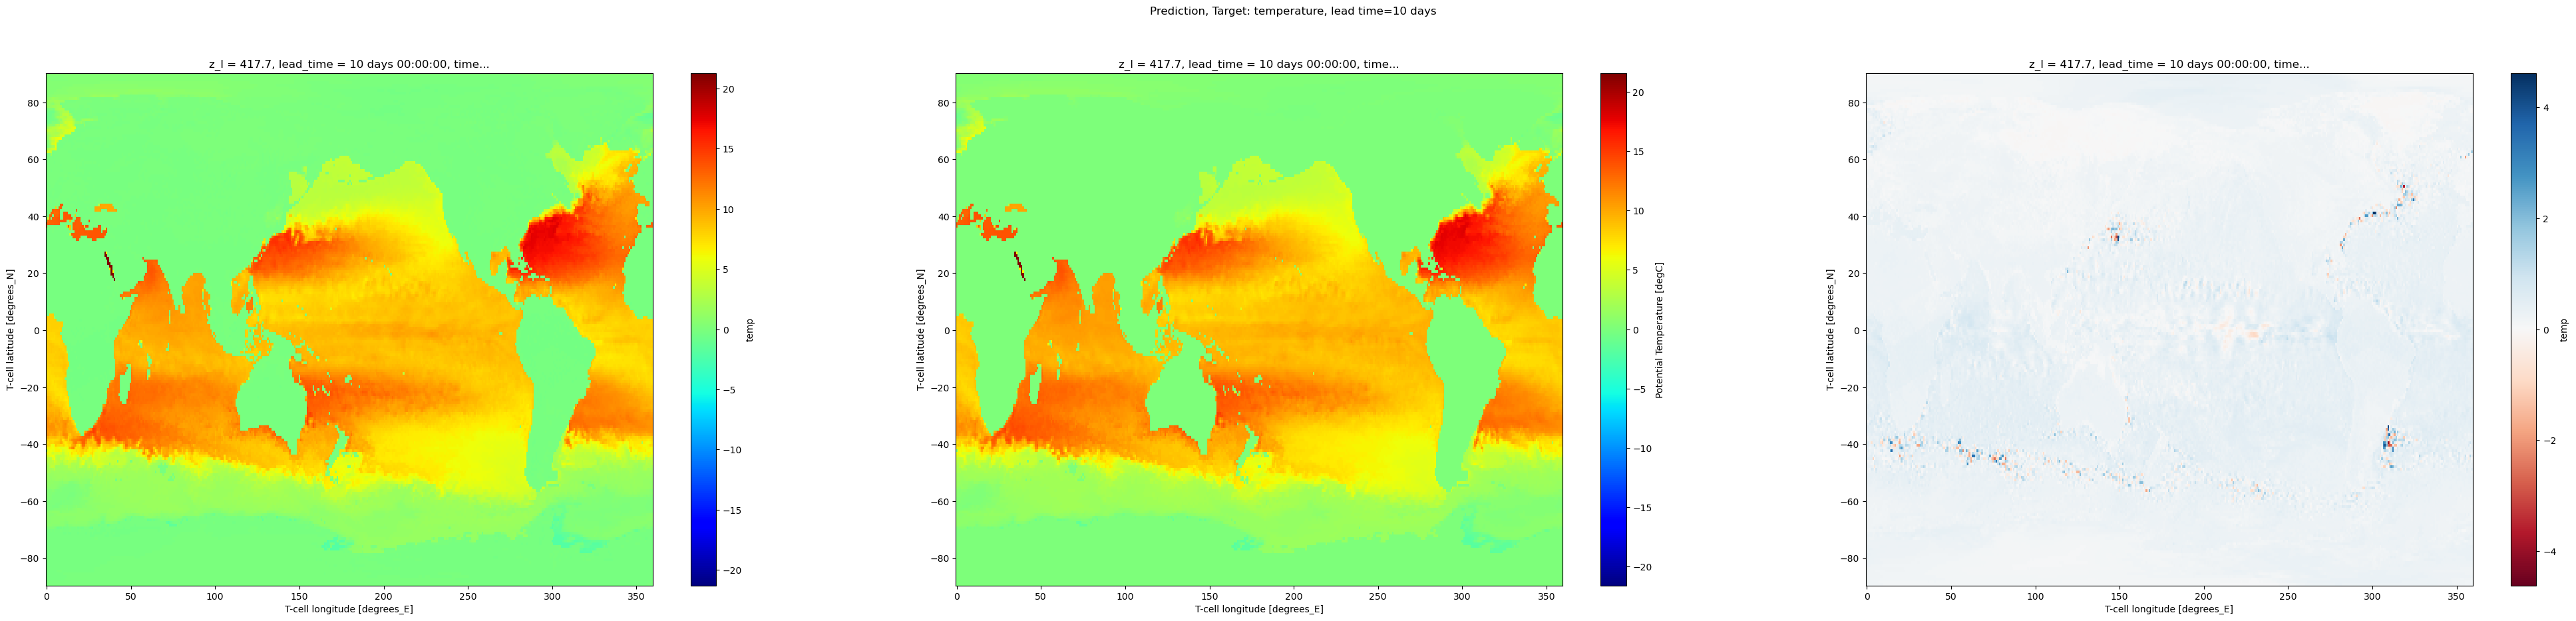

In [12]:
fig, ax = plt.subplots(1, 3, figsize=(50,10))
predictions.temp.isel(time=0, lead_time=-1, z_l=-1).plot(ax=ax[0], cmap="jet")
targets.temp.isel(time=0, lead_time=-1, z_l=-1).plot(ax=ax[1], cmap="jet")
diff = targets.temp.isel(time=0, lead_time=-1, z_l=-1) - predictions.temp.isel(time=0, lead_time=-1, z_l=-1)
diff.plot(ax=ax[2], cmap='RdBu')
lead_time_days = predictions.lead_time[-1].values.astype('timedelta64[D]')
plt.suptitle(f'Prediction, Target: temperature, lead time={lead_time_days}')
plt.show()

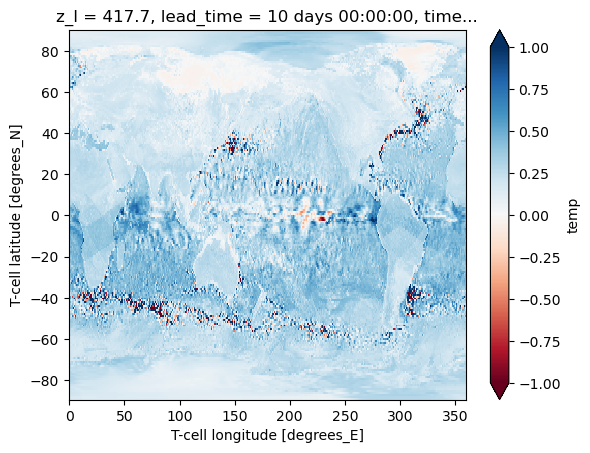

In [13]:
diff.plot(cmap='RdBu', vmin=-1, vmax=1)
plt.show()

In [31]:
print(predictions.lat[50].values)
print(predictions.lon[220].values)

42.979819538909815
206.25


In [35]:
predictions.soilm.isel(lat=50, lon=220, lead_time=-1).values

array([5.740899], dtype=float32)

In [34]:
targets.SSH.isel(lat=50, lon=220, lead_time=-1).values

array([0.08719323], dtype=float32)